# Pre-set

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')

# Problem 1

## Lagrange interpolation

In [2]:
points = np.linspace(-1,1,21)

In [3]:
def runge(x):
    return 1/(1+25*x**2)

In [4]:
def lagrange(x,pts,func):
    pts_lens = pts.shape[0]
    output = 0
    for i in range(pts_lens):
        temp = 1
        for j in range(pts_lens):
            if (i==j):
                continue
            else:
                temp*=(x-pts[j])/(pts[i]-pts[j])
        output+=temp*func(pts[i])
    return output

def lagrange_array(x,pts,func):
    output = [lagrange(i,pts,func) for i in x]
    return np.asarray(output)

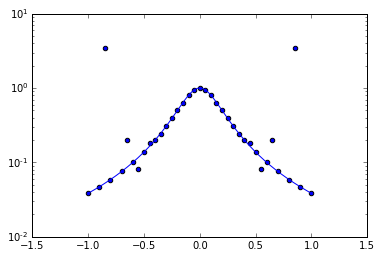

In [5]:
xmid = np.linspace(-1,1,41)
xs = np.linspace(-1,1,1000+1)
plt.figure()
plt.semilogy(xs,runge(xs))
ys = lagrange_array(xmid,points,runge)
plt.scatter(xmid,ys)

## Chebyshev interpolation

In [6]:
def Tn(x,n):
    return np.cos(n*np.arccos(x))

In [7]:
def c_N_m(N,m,func):
    factor = 2 / N
    if m==0:
        factor/=2
    output = 0
    for i in range(N):
        output += np.cos(m*np.pi*(i+0.5)/N)*func(np.cos(np.pi*(i+0.5)/N))
    return output*factor

def Che(x,N,func):
    output = 0
    for i in range(N):
        output+=Tn(x,i)*c_N_m(N,i,func)
    return output

def Che_array(xs,N,func):
    output = [Che(i,N,func) for i in xs]
    return np.asarray(output)

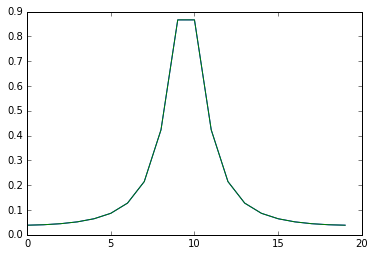

In [8]:
x_che = np.cos(np.pi*(np.arange(0,20)+1/2)/20)
plt.figure()
plt.plot(runge(x_che))
plt.plot(Che_array(x_che,20,runge))

## Cubic Spline interpolation
### with period/nature boundary condition

In [9]:
def Thomas_solver(a,b,c,n,d):
    beta = [c[0]/b[0]]
    for i in range(n-2):
        beta.append(c[i+1]/(b[i+1]-a[i]*beta[i]))
    y = [d[0]/b[0]]
    for i in range(n-1):
        y.append((d[i+1]-a[i]*y[i])/(b[i+1]-a[i]*beta[i]))
    for i in range(n-1):
        y[n-i-2] -= beta[n-i-2]*y[n-i-1]
    return np.asarray(y)

In [10]:
def cubic_sp_M(ptsx, ptsy,bctype = 0):#bctype = 0: period BC, bctype = 1: natural BC
    # common set up
    h = [ptsx[i+1] - ptsx[i] for i in range(len(ptsx)-1)]
    mu = [h[i]/(h[i]+h[i+1]) for i in range(len(h)-1)]
    lam = [h[i+1]/(h[i]+h[i+1]) for i in range(len(h)-1)]
    d = [6*(ptsy[i]/h[i]/(h[i]+h[i+1])+ptsy[i+2]/h[i+1]/(h[i]+h[i+1])-ptsy[i+1]/h[i]/h[i+1]) for i in range(len(h)-1)]
    # set up to different BC
    if (bctype == 0):
        d += [6*((ptsy[1]-ptsy[0])/h[0]-(ptsy[-1]-ptsy[-2])/h[-1])/(h[-1]+h[0])]
        mu += [h[-1]/(h[0]+h[-1])]
        lam += [h[0]/(h[0]+h[-1])]

        mu2lamn = [-mu[1]]+[0 for i in range(len(h)-1-2)]+[-lam[-1]]
        diag = [2 for i in range(len(h)-1)]
        M1 = Thomas_solver(mu[2:],diag,lam[1:-1],len(diag),d[1:])
        M2 = Thomas_solver(mu[2:],diag,lam[1:-1],len(diag),mu2lamn)

        M = [(d[0]-lam[0]*M1[0]-mu[0]*M1[-1])/(2+lam[0]*M2[0]+mu[0]*M2[-1])]
        M += [i for i in (M1+M[0]*M2)]
        M = [M[-1]] + M
        return np.asarray(M), np.asarray(h)
    else:
        d = [0] + d + [0]
        lam = [0] + lam
        mu = mu + [0]
        diag = [2 for i in range(len(h)+1)]
        return Thomas_solver(mu,diag,lam,len(diag),d),np.asarray(h)

In [11]:
cubic_sp_M(points,runge(points),bctype=1)

(array([  0.        ,   0.36154331,   0.45427926,   0.75141735,
          1.26813126,   2.21769719,   4.34383862,   7.78095365,
         15.30157757,  -4.37187931, -57.81406035,  -4.37187931,
         15.30157757,   7.78095365,   4.34383862,   2.21769719,
          1.26813126,   0.75141735,   0.45427926,   0.36154331,
          0.        ]),
 array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
        0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]))

In [12]:
def cubic_sp_plot(ptsx,ptsy,bctype = 0,ifplot = True,number=20):
    M,h = cubic_sp_M(ptsx,ptsy,bctype)
    x = np.asarray([])
    y = np.asarray([])
    for i in range(len(ptsy)-1):
        if(i==0):
            xs = np.linspace(ptsx[i],ptsx[i+1],number+1)
        else:
            xs = np.linspace(ptsx[i],ptsx[i+1],number+1)[1:]
        ys = M[i]/6/h[i]*np.power(ptsx[i+1]-xs,3)+M[i+1]/6/h[i]*np.power(xs-ptsx[i],3)+(ptsy[i]-M[i]*h[i]**2/6)*(ptsx[i+1]-xs)/h[i]+(ptsy[i+1]-M[i+1]*h[i]**2/6)*(xs-ptsx[i])/h[i]
        x = np.concatenate((x,xs))
        y = np.concatenate((y,ys))
    if(ifplot):
        plt.figure()
        plt.plot(x,y)
    return x,y

In [13]:
def cubic_sp_points(ptsx,ptsy,bctype=0):
    M,h = cubic_sp_M(ptsx,ptsy,bctype)
    x = np.asarray([])
    y = np.asarray([])
    for i in range(len(ptsy)-1):
        x_mid = (ptsx[i]+ptsx[i+1])/2
        if (i == 0):
            xs = np.asarray([ptsx[i],x_mid,ptsx[i+1]])
        else:
            xs = np.asarray([x_mid,ptsx[i+1]])
        ys = M[i]/6/h[i]*np.power(ptsx[i+1]-xs,3)+M[i+1]/6/h[i]*np.power(xs-ptsx[i],3)+(ptsy[i]-M[i]*h[i]**2/6)*(ptsx[i+1]-xs)/h[i]+(ptsy[i+1]-M[i+1]*h[i]**2/6)*(xs-ptsx[i])/h[i]
        x = np.concatenate((x,xs))
        y =np.concatenate((y,ys))
    return x,y

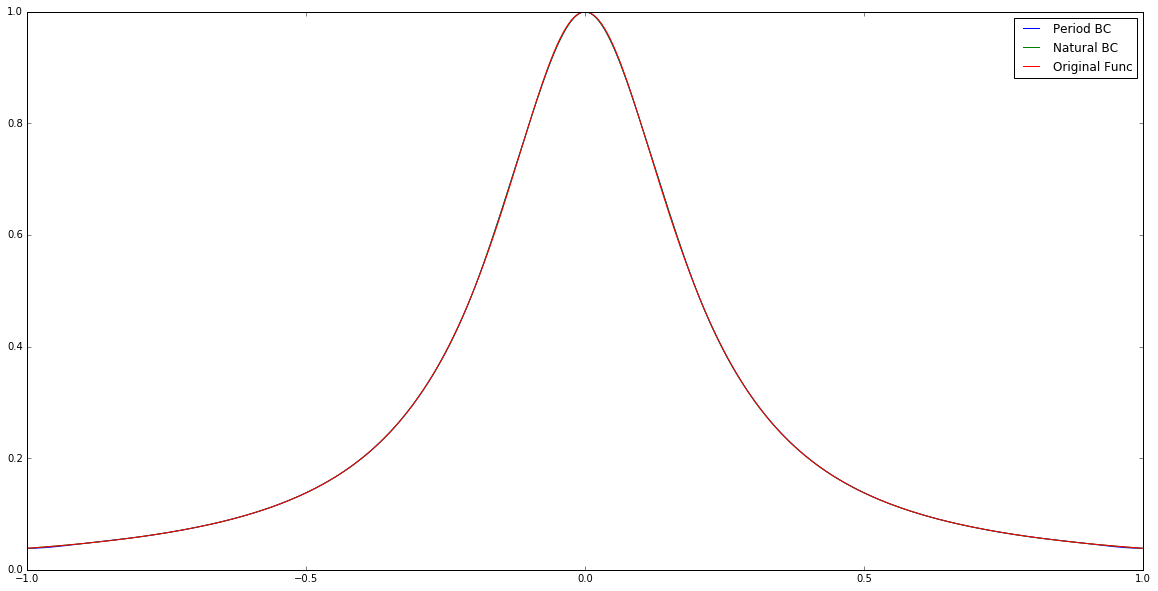

In [14]:
x_per,y_per = cubic_sp_plot(points,runge(points),ifplot=False)
x_nat,y_nat = cubic_sp_plot(points,runge(points),bctype=1,ifplot=False)
plt.figure(figsize=(20,10))
plt.plot(x_per,y_per,label='Period BC')
plt.plot(x_per,y_nat,label='Natural BC')
plt.plot(x_per,runge(x_per),label='Original Func')
plt.legend()

# Problem 2

## construct coordinates

In [15]:
def r(phi):
    return 1-np.cos(phi)

In [16]:
t = np.arange(0,9)
print(t)
phi= np.pi/4*t
rt = [r(i) for i in phi]
xt = [rt[i]*np.cos(phi[i]) for i in t]
yt = [rt[i]*np.sin(phi[i]) for i in t]

for i in range(9):
    print(xt[i],yt[i],t[i],rt[i])

[0 1 2 3 4 5 6 7 8]
0.0 0.0 0 0.0
0.20710678118654752 0.20710678118654746 1 0.2928932188134524
6.123233995736765e-17 0.9999999999999999 2 0.9999999999999999
-1.2071067811865475 1.2071067811865475 3 1.7071067811865475
-2.0 2.4492935982947064e-16 4 2.0
-1.207106781186548 -1.2071067811865475 5 1.7071067811865477
-1.8369701987210302e-16 -1.0000000000000002 6 1.0000000000000002
0.2071067811865476 -0.20710678118654768 7 0.29289321881345265
0.0 -0.0 8 0.0


## get Ms for cubic spline

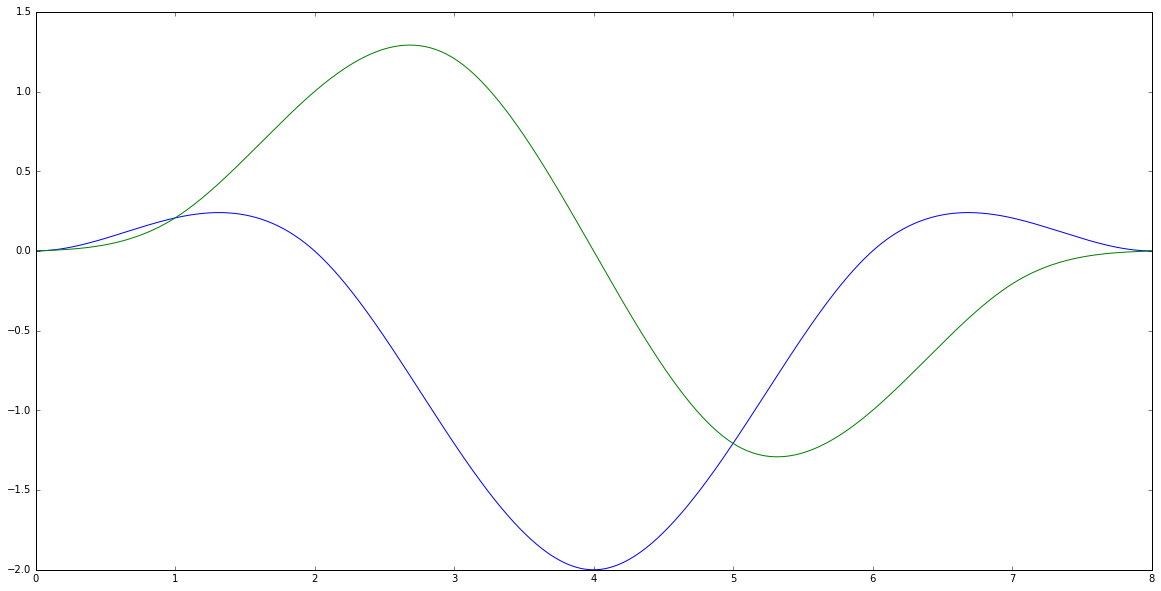

In [17]:
Mx,hx = cubic_sp_M(t,xt)
My,hy = cubic_sp_M(t,yt)

t_sp1,x_sp = cubic_sp_plot(t,xt,bctype=0,ifplot=False,number=100)
t_sp2,y_sp = cubic_sp_plot(t,yt,bctype=0,ifplot=False,number=100)

plt.figure(figsize=(20,10))
plt.plot(t_sp1,x_sp)
plt.plot(t_sp2,y_sp)

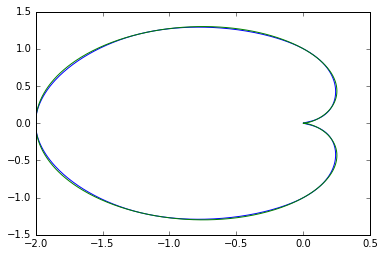

In [18]:
plt.plot(x_sp,y_sp)
t_real = np.linspace(0,2*np.pi,1000+1)
x_real = [r(i)*np.cos(i) for i in t_real]
y_real = [r(i)*np.sin(i) for i in t_real]
plt.plot(x_real,y_real)

## Problem 3

### Series Trunctuation

SyntaxError: invalid syntax (<ipython-input-19-ff089be6f4de>, line 2)